In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
import sys

sys.path.append("../")

In [14]:
import fof.dataloader
import transformers as tr
from pathlib import Path
import torchvision

In [19]:
loader = fof.dataloader.ScicapDataModule(
  "First-Sentence",
  tokenizer=tr.AutoTokenizer.from_pretrained("distilbert-base-uncased"),
  root=Path("../scicap_data"),
  batch_size=4,
  caption_type="orig",
  num_workers=0, transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
  ]))
train = loader.train_dataloader()

Initializing SCICAP training dataset
Initializing SCICAP testing dataset
Initializing SCICAP validation dataset
Time taken: 0.053581953048706055


In [20]:
batch = next(iter(train))
len(batch)

6

In [ ]:
batch["figure"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


references wever, Table 2 reveals that its overall
accuracy remains competitive with other model-free methods. Figure 9 shows the shape of the density contours near the
shockwave along the three dashed cut planes in Fig
labels Fig. 9 Density contours for the fully connected network predictions (red), cluster network predictions (blue), and the full order solutions (black) for the shock-induced bubble for one example in the test set at t = 0.18s and M = 1.8 along three cut planes taken near the shockwave at the dashed lines in Figure 8.
title Fast Neural Network Predictions from Constrained Aerodynamics Datasets
id 1902.00091v5-Figure9-1.png
abstract   Incorporating computational fluid dynamics in the design process of jets,
spacecraft, or gas turbine engines is often challenged by the required
computational resources and simulation time, which depend on the chosen
physics-based computational models and grid resolutions. An ongoing problem in
the field is how to simulate these systems f

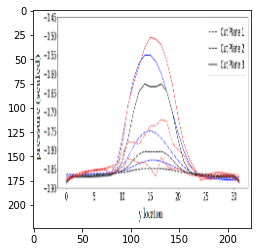

In [24]:
for key in ["references", "labels", "title", "id", "abstract"]:
    print(key, batch[key][0])

import matplotlib.pyplot as plt
plt.imshow(batch["figure"][0].permute(1, 2, 0) / 255)